# Explicit Chang Cooper Scheme

## Imports

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Model Parameters

In [21]:
sigma = 0.001
beta = 100
lamda = 0.6
alpha = 0.1
v0 = 0.01
vg = 0
psi = np.inf
D0 = 0.001

## Vectorized Drift and Diffusion Functions

In [22]:
def mu_x_vec(X, Z, PHI, t):
    """Vectorized x-direction drift"""
    return alpha*np.exp(Z)*np.cos(X-t) + v0*np.sin(PHI) + sigma*(beta+Z)

def mu_z_vec(X, Z, PHI, t):
    """Vectorized z-direction drift"""
    return alpha*np.exp(Z)*np.sin(X-t) + v0*np.cos(PHI) - vg

def mu_phi_vec(X, Z, PHI, t):
    """Vectorized phi-direction drift"""
    return (lamda*alpha*np.exp(Z)*np.cos(X-t+2*PHI) - 
            1/(2*psi)*np.sin(PHI) + 
            sigma/2*(1+lamda*np.cos(2*PHI)))

def var_vec(X, Z, PHI, t):
    """Vectorized noise intensity"""
    # TODO: Is it not like PHI
    return D0 * np.ones_like(X)

# Extremized functions for CFL condition

def mu_x_max(X, Z, PHI, t):
    """Vectorized x-direction drift"""
    return alpha*np.exp(Z) + v0 + sigma*(beta+Z)

def mu_z_max(X, Z, PHI, t):
    """Vectorized z-direction drift"""
    return alpha*np.exp(Z) + v0 - vg

def mu_phi_max(X, Z, PHI, t):
    """Vectorized phi-direction drift"""
    return (lamda*alpha*np.exp(Z)- 1/(2*psi) + sigma/2*(1+lamda))



## Chang-Cooper Helpers

In [23]:
def delta_cc_vec(Pe):
    """Vectorized Chang-Cooper delta function"""
    delta = np.zeros_like(Pe)
    
    # Small Pe: use limiting value
    small = np.abs(Pe) < 1e-10
    delta[small] = 0.5
    
    # Normal Pe
    large = ~small
    delta[large] = 1.0/Pe[large] - 1.0/(np.exp(Pe[large]) - 1.0)
    
    return delta

def apply_periodic_bc(arr, axis):
    """Apply periodic boundary conditions along an axis"""
    return np.roll(arr, 0, axis=axis)  # Identity, already periodic in indexing

def max_velocities(x_grid, z_grid, phi_grid, t=0):
    """Compute maximum absolute drift velocities in each direction"""
    x_max = np.abs(mu_x_max(x_grid, z_grid, phi_grid, t)).max()
    z_max = np.abs(mu_z_max(x_grid, z_grid, phi_grid, t)).max()
    phi_max = np.abs(mu_phi_max(x_grid, z_grid, phi_grid, t)).max()

    return x_max, z_max, phi_max


## Vectorized Fokker-Planck Step

In [24]:
def fokker_planck_step_vectorized(f, X, Z, PHI, t, dt, dx, dz, dphi,
                                   bc_x='open', bc_z='noflux', bc_phi='periodic'):
    """
    Fully vectorized explicit Euler step for 3D Fokker-Planck equation
    
    All operations use NumPy array operations - no Python loops!
    """
    Nx, Nz, Nphi = f.shape
    
    # ========== Compute drift coefficients everywhere ==========
    MU_X = mu_x_vec(X, Z, PHI, t)
    MU_Z = mu_z_vec(X, Z, PHI, t)
    MU_PHI = mu_phi_vec(X, Z, PHI, t)
    VAR = var_vec(X, Z, PHI, t)
    D = 0.5 * VAR**2
    
    # ========== X-direction fluxes (upwind) ==========
    # Face velocities at i+1/2 (average between neighbors)
    MU_X_face_p = 0.5 * (MU_X + np.roll(MU_X, -1, axis=0))
    
    # Upwind flux: use upstream value
    F_x_p = np.where(MU_X_face_p >= 0, 
                     MU_X_face_p * f,                    # Forward
                     MU_X_face_p * np.roll(f, -1, axis=0))  # Backward
    
    # Face velocities at i-1/2
    MU_X_face_m = 0.5 * (np.roll(MU_X, 1, axis=0) + MU_X)
    
    F_x_m = np.where(MU_X_face_m >= 0,
                     MU_X_face_m * np.roll(f, 1, axis=0),
                     MU_X_face_m * f)
    
    # Apply x boundary conditions
    if bc_x == 'open':
        # Left boundary (i=0): only allow outflow
        F_x_m[0, :, :] = np.minimum(0, MU_X[0, :, :]) * f[0, :, :]
        # Right boundary (i=-1): only allow outflow
        F_x_p[-1, :, :] = np.maximum(0, MU_X[-1, :, :]) * f[-1, :, :]
    elif bc_x == 'noflux':
        F_x_m[0, :, :] = 0.0
        F_x_p[-1, :, :] = 0.0
    # periodic: already handled by roll
    
    # Divergence in x
    div_x = -(F_x_p - F_x_m) / dx
    
    # ========== Z-direction fluxes (upwind) ==========
    MU_Z_face_p = 0.5 * (MU_Z + np.roll(MU_Z, -1, axis=1))
    
    F_z_p = np.where(MU_Z_face_p >= 0,
                     MU_Z_face_p * f,
                     MU_Z_face_p * np.roll(f, -1, axis=1))
    
    MU_Z_face_m = 0.5 * (np.roll(MU_Z, 1, axis=1) + MU_Z)
    
    F_z_m = np.where(MU_Z_face_m >= 0,
                     MU_Z_face_m * np.roll(f, 1, axis=1),
                     MU_Z_face_m * f)
    
    # Apply z boundary conditions (no-flux)
    if bc_z == 'noflux':
        F_z_m[:, 0, :] = 0.0
        F_z_p[:, -1, :] = 0.0
    
    # Divergence in z
    div_z = -(F_z_p - F_z_m) / dz
    
    # ========== Phi-direction Chang-Cooper fluxes ==========
    # Face values at k+1/2
    MU_PHI_face_p = 0.5 * (MU_PHI + np.roll(MU_PHI, -1, axis=2))
    D_face_p = 0.5 * (D + np.roll(D, -1, axis=2))
    
    # Peclet number
    Pe_p = MU_PHI_face_p * dphi / (D_face_p + 1e-16)  # Avoid division by zero
    delta_p = delta_cc_vec(Pe_p)
    
    # Chang-Cooper flux at k+1/2
    f_rolled_p = np.roll(f, -1, axis=2)
    J_phi_p = (MU_PHI_face_p * (1.0 - delta_p) * f_rolled_p + 
               MU_PHI_face_p * delta_p * f - 
               D_face_p * (f_rolled_p - f) / dphi)
    
    # Face values at k-1/2
    MU_PHI_face_m = 0.5 * (np.roll(MU_PHI, 1, axis=2) + MU_PHI)
    D_face_m = 0.5 * (np.roll(D, 1, axis=2) + D)
    
    Pe_m = MU_PHI_face_m * dphi / (D_face_m + 1e-16)
    delta_m = delta_cc_vec(Pe_m)
    
    # Chang-Cooper flux at k-1/2
    f_rolled_m = np.roll(f, 1, axis=2)
    J_phi_m = (MU_PHI_face_m * (1.0 - delta_m) * f + 
               MU_PHI_face_m * delta_m * f_rolled_m - 
               D_face_m * (f - f_rolled_m) / dphi)
    
    # Phi is periodic by default (handled by roll)
    
    # Divergence in phi
    div_phi = -(J_phi_p - J_phi_m) / dphi
    
    # ========== Update ==========
    dfdt = div_x + div_z + div_phi
    f_new = f + dt * dfdt
    
    # Enforce positivity (clip small negative values from roundoff)
    f_new = np.maximum(f_new, 0.0)
    
    return f_new


## Time Integration

In [25]:
def solve_fokker_planck_vectorized(f0, t_array, x_grid, z_grid, phi_grid,
                                    bc_x='open', bc_z='noflux', bc_phi='periodic',
                                    verbose=True, live_plot=False, plot_interval=50):
    """Time integration using vectorized solver with optional live plotting"""
    Nt = len(t_array)
    Nx, Nz, Nphi = f0.shape
    
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    # Create meshgrids (only once!)
    X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')
    
    solution = np.zeros((Nt, Nx, Nz, Nphi))
    solution[0] = f0.copy()
    
    f = f0.copy()
    
    # Setup live plotting if requested
    if live_plot:
        plt.ion()
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('Live Fokker-Planck Evolution', fontsize=14)
    
    if verbose:
        print("Starting vectorized time integration...")
    
    for n in range(Nt - 1):
        dt = t_array[n+1] - t_array[n]
        t = t_array[n]
        
        f = fokker_planck_step_vectorized(f, X, Z, PHI, t, dt, dx, dz, dphi,
                                          bc_x, bc_z, bc_phi)
        
        solution[n+1] = f
        
        # Check for issues
        if np.any(np.isnan(f)):
            print(f"❌ NaN detected at step {n+1}!")
            break
        
        if np.any(f < -1e-10):
            neg_count = np.sum(f < -1e-10)
            if verbose and (n+1) % 100 == 0:
                print(f"⚠️  {neg_count} negative values at step {n+1}: min={np.min(f):.3e}")
        
        # Monitor progress
        if verbose and ((n+1) % 100 == 0 or n == 0):
            total_prob = np.sum(f) * dx * dz * dphi
            min_val = np.min(f)
            max_val = np.max(f)
            print(f"Step {n+1}/{Nt-1}, t={t_array[n+1]:.4f}, "
                  f"∫f={total_prob:.6f}, min={min_val:.3e}, max={max_val:.3e}")
        
        # Live plotting
        if live_plot and (n+1) % plot_interval == 0:
            plot_state(f, x_grid, z_grid, phi_grid, t_array[n+1], axes, fig)
    
    if live_plot:
        plt.ioff()
        plt.show()
    
    return solution

## CFL Condition

Since there is no diffusion in the ( x )- and ( z )-directions, we focus on the **advection** in these directions and the **diffusion** in the ( $\phi $)-direction.

#### Advection (in ( x ) and ( z )):

For **advection**, the CFL condition is given by:

$
\text{CFL}_{\text{adv,x}} = \frac{|\mu|{\text{max}}| \Delta t}{\Delta x} \leq 1
$

where ($ \mu_{\text{max}}$ ) is the maximum value of the drift velocity in the respective direction (either ($ \mu_x $) or ( $\mu_z $)), and ( $\Delta x $) is the grid spacing in the ( x )-direction (or ( z )-direction). For ( z ), this would similarly be:

$
\text{CFL}_{\text{adv,z}} = \frac{|\mu_z| \Delta t}{\Delta z} \leq 1
$

This ensures that the drift velocity doesn't carry the solution too far in a single time step.

#### Diffusion (in ( $\phi$ )):

For **diffusion** in the ( $\phi$ )-direction, the CFL condition comes from the second derivative in space, and it looks like this:

$
\text{CFL}_{\text{diff}} = \frac{D*\phi \Delta t}{\Delta \phi^2} \leq \frac{1}{2}
$

Where ( $D_\phi$ ) is the diffusion coefficient in the ( $\phi$ )-direction and ( $\Delta \phi$ ) is the grid spacing in the ( $\phi$ )-direction. This condition ensures that the diffusion doesn't cause "leaping" over too many grid points in one time step.

### Overall CFL Condition:

1. For the **advection in the ( x )-direction**:
   $
   \frac{|\mu_x| \Delta t}{\Delta x} \leq 1
   $

2. For the **advection in the ( z )-direction**:
   $
    \frac{|\mu_z| \Delta t}{\Delta z} \leq 1
   $

3. For the **diffusion in the ( $\phi$ )-direction**:
   $
   \frac{D_\phi \Delta t}{\Delta \phi^2} \leq \frac{1}{2}
   $


In [26]:
def check_cfl_condition(x_grid, z_grid, phi_grid, dt, t=0):
    """Check CFL stability condition"""
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    D_max = D0
    max_mu_x, max_mu_z, max_mu_phi = (0.01, 0.01, 0.01)
    max_mu_x, max_mu_z, max_mu_phi = max_velocities(x_grid, z_grid, phi_grid, t)

    if D_max > 0:
        dt_max_x = dx / max_mu_x
        dt_max_z = dz / max_mu_z
        dt_max_phi = dphi**2 / (2 * D_max)
        dt_max = min(dt_max_x, dt_max_z, dt_max_phi)
        
        print(f"CFL check: dt={dt:.4e}, dt_max={dt_max:.4e}")
        if dt > 0.5 * dt_max:
            print(f"Warning: dt may be too large for stability!")
        else:
            print(f"✓ CFL condition satisfied")
    
    return dt

## Plotting Functions

In [27]:
def plot_state(f, x_grid, z_grid, phi_grid, t, axes, fig):
    """Update live plot with current state"""
    for ax in axes.flat:
        ax.clear()
    
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    # 1. Marginal in (x, z) - integrate over phi
    f_xz = np.sum(f, axis=2) * dphi
    im1 = axes[0, 0].contourf(x_grid, z_grid, f_xz.T, levels=20, cmap='viridis')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('z')
    axes[0, 0].set_title(f'Marginal f(x,z) at t={t:.3f}')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # 2. Marginal in (x, phi) - integrate over z
    f_xphi = np.sum(f, axis=1) * dz
    im2 = axes[0, 1].contourf(x_grid, phi_grid, f_xphi.T, levels=20, cmap='plasma')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('φ')
    axes[0, 1].set_title(f'Marginal f(x,φ)')
    plt.colorbar(im2, ax=axes[0, 1])
    
    # 3. Marginal in (z, phi) - integrate over x
    f_zphi = np.sum(f, axis=0) * dx
    im3 = axes[1, 0].contourf(z_grid, phi_grid, f_zphi.T, levels=20, cmap='coolwarm')
    axes[1, 0].set_xlabel('z')
    axes[1, 0].set_ylabel('φ')
    axes[1, 0].set_title(f'Marginal f(z,φ)')
    plt.colorbar(im3, ax=axes[1, 0])
    
    # 4. 1D marginals
    f_x = np.sum(f, axis=(1, 2)) * dz * dphi
    f_z = np.sum(f, axis=(0, 2)) * dx * dphi
    f_phi = np.sum(f, axis=(0, 1)) * dx * dz
    
    axes[1, 1].plot(x_grid, f_x, 'b-', label='f(x)', linewidth=2)
    axes[1, 1].plot(z_grid, f_z, 'r-', label='f(z)', linewidth=2)
    axes[1, 1].plot(phi_grid, f_phi, 'g-', label='f(φ)', linewidth=2)
    axes[1, 1].set_xlabel('Coordinate')
    axes[1, 1].set_ylabel('Probability density')
    axes[1, 1].set_title('1D Marginals')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    fig.tight_layout()
    plt.pause(0.01)

def plot_summary(solution, t_array, x_grid, z_grid, phi_grid, save_path=None):
    """Create comprehensive summary plots after simulation"""
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    fig = plt.figure(figsize=(16, 10))
    
    # Select key time points
    time_indices = [0, len(t_array)//4, len(t_array)//2, 3*len(t_array)//4, -1]
    
    for idx, ti in enumerate(time_indices):
        f = solution[ti]
        t = t_array[ti]
        
        # Plot marginal in (x, z)
        ax = plt.subplot(3, 5, idx+1)
        f_xz = np.sum(f, axis=2) * dphi
        im = ax.contourf(x_grid, z_grid, f_xz.T, levels=15, cmap='viridis')
        ax.set_xlabel('x')
        ax.set_ylabel('z')
        ax.set_title(f't={t:.3f}')
        plt.colorbar(im, ax=ax)
        
        # Plot marginal in (x, phi)
        ax = plt.subplot(3, 5, idx+6)
        f_xphi = np.sum(f, axis=1) * dz
        im = ax.contourf(x_grid, phi_grid, f_xphi.T, levels=15, cmap='plasma')
        ax.set_xlabel('x')
        ax.set_ylabel('φ')
        plt.colorbar(im, ax=ax)
        
        # Plot 1D marginals
        ax = plt.subplot(3, 5, idx+11)
        f_x = np.sum(f, axis=(1, 2)) * dz * dphi
        f_z = np.sum(f, axis=(0, 2)) * dx * dphi
        f_phi = np.sum(f, axis=(0, 1)) * dx * dz
        ax.plot(x_grid, f_x, 'b-', label='f(x)', alpha=0.7)
        ax.plot(z_grid, f_z, 'r-', label='f(z)', alpha=0.7)
        ax.plot(phi_grid, f_phi, 'g-', label='f(φ)', alpha=0.7)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Coordinate')
    
    plt.suptitle('Fokker-Planck Evolution Summary', fontsize=16, y=0.995)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Summary plot saved to: {save_path}")
    
    plt.show()
    
    return fig

## Run Program

### Timearray and Grid Setup

In [44]:
t_final = 400.0
dt = 0.02  # Reduced from 0.001 for better stability
Nt = int(t_final / dt) + 1
t_array = np.linspace(0, t_final, Nt)

# Grid setup
Nx, Nz, Nphi = 10, 10, 40
x_grid = np.linspace(0, 20, Nx)
z_grid = np.linspace(-4, 0, Nz)
phi_grid = np.linspace(0, 2*np.pi, Nphi)

dx = x_grid[1] - x_grid[0]
dz = z_grid[1] - z_grid[0]
dphi = phi_grid[1] - phi_grid[0]

check_cfl_condition(x_grid, z_grid, phi_grid, dt)

CFL check: dt=2.0000e-02, dt_max=4.0404e+00
✓ CFL condition satisfied


0.02

### Initial State - localized Gaussian

In [45]:
# Initial condition: localized Gaussian
X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')
x0, z0, phi0 = 0.0, -2.0, np.pi
sigma_init = 0.1

f0 = np.exp(-((X-x0)**2 + (Z-z0)**2 + (PHI-phi0)**2)/(2*sigma_init**2))
f0 = f0 / (np.sum(f0) * dx * dz * dphi)

VECTORIZED 3D FOKKER-PLANCK SOLVER
Grid: 10×10×40 = 4,000 cells
Resolution: dx=2.222, dz=0.444, dφ=0.161
Initial ∫f = 1.000000

Time: t ∈ [0, 400.0], dt=2.0000e-02, Nt=20001
CFL check: dt=2.0000e-02, dt_max=4.0404e+00
✓ CFL condition satisfied

Starting vectorized time integration...
Step 1/20000, t=0.0200, ∫f=1.000000, min=0.000e+00, max=1.461e+00


/tmp/ipykernel_12480/1328731531.py:11: RuntimeWarning: overflow encountered in exp
  delta[large] = 1.0/Pe[large] - 1.0/(np.exp(Pe[large]) - 1.0)


Step 100/20000, t=2.0000, ∫f=1.000782, min=0.000e+00, max=1.410e+00
Step 200/20000, t=4.0000, ∫f=1.003471, min=0.000e+00, max=1.283e+00
Step 300/20000, t=6.0000, ∫f=1.019172, min=0.000e+00, max=1.208e+00
Step 400/20000, t=8.0000, ∫f=1.046819, min=0.000e+00, max=1.173e+00
Step 500/20000, t=10.0000, ∫f=1.072775, min=0.000e+00, max=1.063e+00
Step 600/20000, t=12.0000, ∫f=1.106555, min=0.000e+00, max=9.926e-01
Step 700/20000, t=14.0000, ∫f=1.142850, min=0.000e+00, max=9.680e-01
Step 800/20000, t=16.0000, ∫f=1.174225, min=0.000e+00, max=8.759e-01
Step 900/20000, t=18.0000, ∫f=1.207971, min=0.000e+00, max=8.120e-01
Step 1000/20000, t=20.0000, ∫f=1.247942, min=0.000e+00, max=7.926e-01
Step 1100/20000, t=22.0000, ∫f=1.282214, min=0.000e+00, max=7.184e-01
Step 1200/20000, t=24.0000, ∫f=1.317372, min=0.000e+00, max=7.069e-01
Step 1300/20000, t=26.0000, ∫f=1.359905, min=0.000e+00, max=7.066e-01
Step 1400/20000, t=28.0000, ∫f=1.397804, min=0.000e+00, max=7.404e-01
Step 1500/20000, t=30.0000, ∫f=1.

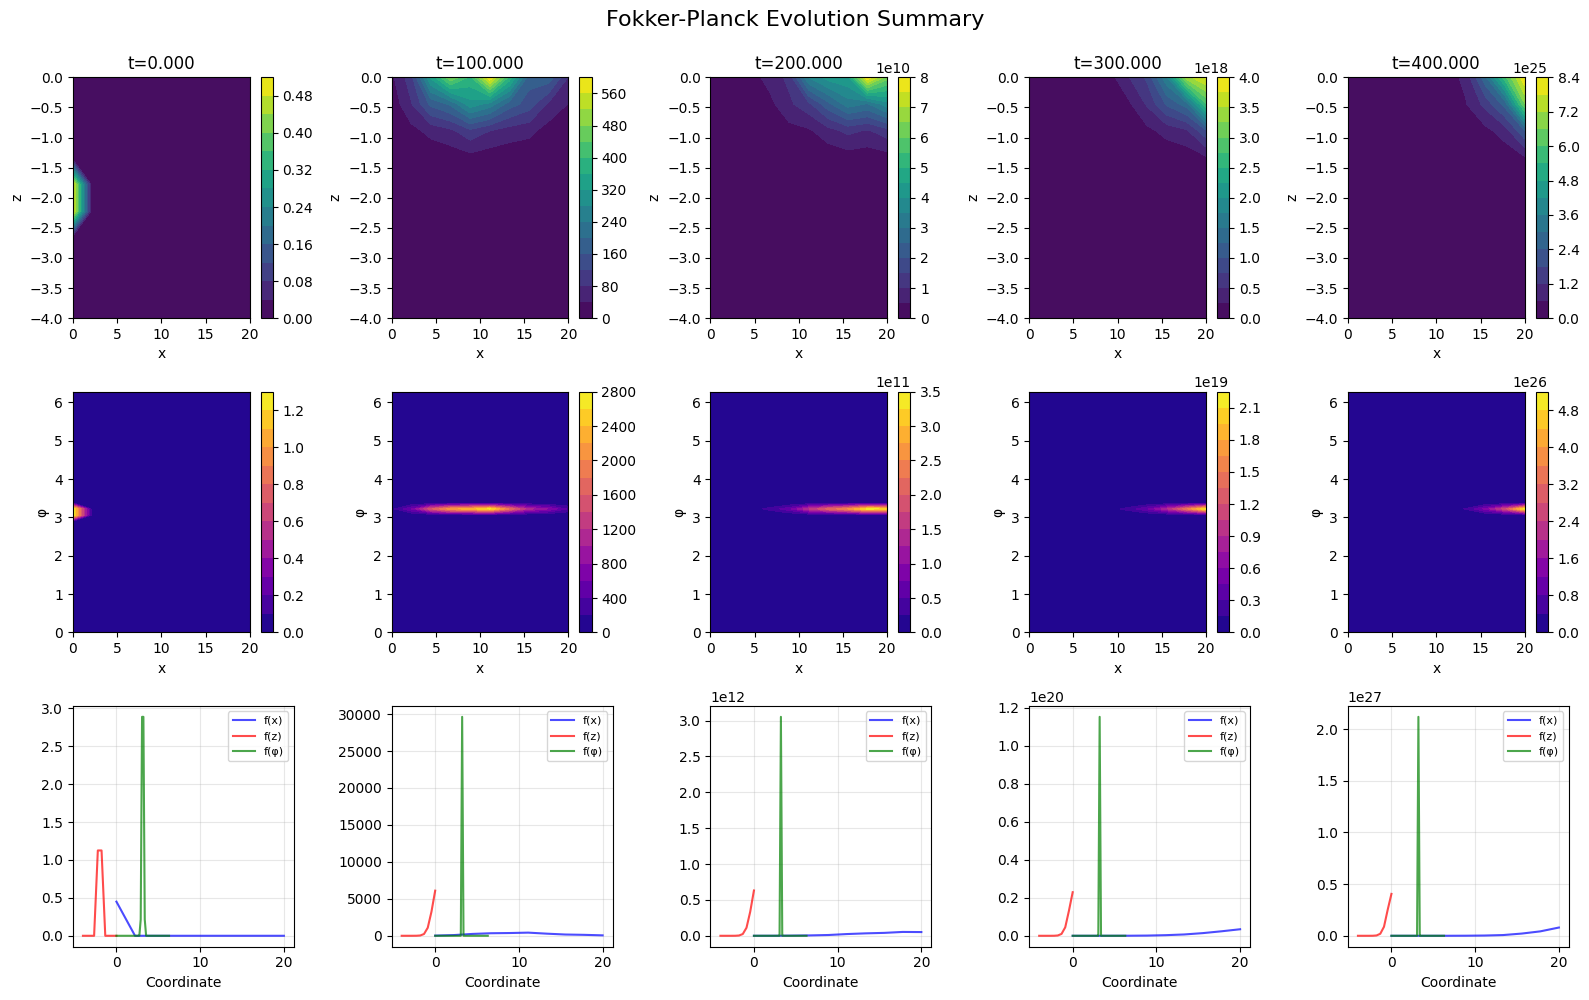

Done


In [46]:
import time


print("="*60)
print("VECTORIZED 3D FOKKER-PLANCK SOLVER")
print("="*60)
print(f"Grid: {Nx}×{Nz}×{Nphi} = {Nx*Nz*Nphi:,} cells")
print(f"Resolution: dx={dx:.3f}, dz={dz:.3f}, dφ={dphi:.3f}")

print(f"Initial ∫f = {np.sum(f0)*dx*dz*dphi:.6f}")
print()

print(f"Time: t ∈ [0, {t_final}], dt={dt:.4e}, Nt={Nt}")
check_cfl_condition(x_grid, z_grid, phi_grid, dt)
print()

# Solve with live plotting
start_time = time.time()

# Set live_plot=True to see real-time updates (slower)
# Set live_plot=False for faster computation, then plot after
use_live_plot = False  # Change to True for live visualization

solution = solve_fokker_planck_vectorized(f0, t_array, x_grid, z_grid, phi_grid,
                                            bc_x='open', bc_z='noflux', bc_phi='periodic',
                                            live_plot=use_live_plot, plot_interval=100)

elapsed = time.time() - start_time

print()
print("="*60)
print(f"✓ Done! Solution shape: {solution.shape}")
print(f"Final ∫f = {np.sum(solution[-1])*dx*dz*dphi:.6f}")
print(f"Computation time: {elapsed:.2f} seconds")
print(f"   ({elapsed/Nt:.4f} sec/step, {Nx*Nz*Nphi*Nt/elapsed/1e6:.2f} Mcells/sec)")
print("="*60)

# Create summary plots
print("\nGenerating summary plots...")
plot_summary(solution, t_array, x_grid, z_grid, phi_grid, 
                save_path=f'./Plots/fokker_planck_summary_{time.time()}.png')
print("Done")

In [47]:
solution.shape

(20001, 10, 10, 40)

## Expected Path

In [48]:
import numpy as np

def expected_path(solution, x_grid, z_grid, phi_grid):
    Nt, Nx, Nz, Nphi = solution.shape
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    # Precompute grids
    X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')
    
    cell_vol = dx * dz * dphi
    
    # Arrays to store the expectation values at each timestep
    X_exp = np.zeros(Nt)
    Z_exp = np.zeros(Nt)
    PHI_exp = np.zeros(Nt)
    
    for n in range(Nt):
        f = solution[n]
        
        # Compute expected values for x, z, phi
        X_exp[n] = np.sum(X * f) * cell_vol / np.sum(f)  # Expectation value of x
        Z_exp[n] = np.sum(Z * f) * cell_vol / np.sum(f)  # Expectation value of z
        PHI_exp[n] = np.sum(PHI * f) * cell_vol / np.sum(f)  # Expectation value of phi
    
    return X_exp, Z_exp, PHI_exp

# Example usage
X_exp, Z_exp, PHI_exp = expected_path(solution, x_grid, z_grid, phi_grid)


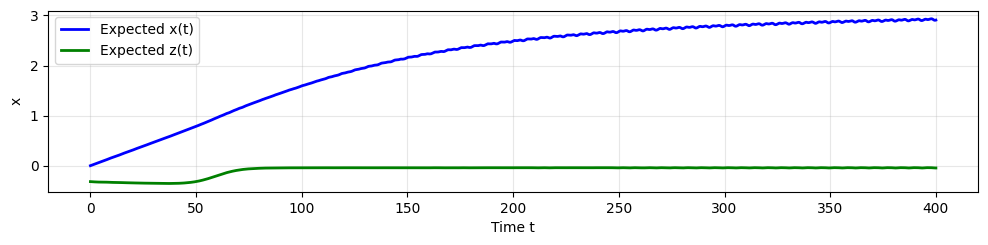

In [49]:
# Plot expected and modal paths
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(t_array, X_exp, 'b-', label='Expected x(t)', linewidth=2)
plt.plot(t_array, Z_exp, 'g-', label='Expected z(t)', linewidth=2)
# plt.plot(t_array, x_mode, 'r--', label='Modal x(t)', linewidth=2)
# plt.plot(t_array, z_mode, 'g--', label='Modal z(t)', linewidth=2)
plt.xlabel('Time t')
plt.ylabel('x')
plt.legend()
plt.grid(True, alpha=0.3)   

In [ ]:
check_cfl_condition(x_grid, z_grid, phi_grid, dt)

CFL check: dt=5.0000e-04, dt_max=4.3259e-02
✓ CFL condition satisfied


0.0005